<a href="https://colab.research.google.com/github/Rintaro0804/ai-practice/blob/main/cnn_aug_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

データを読み込んでいます...
水増し画像の例を表示します...


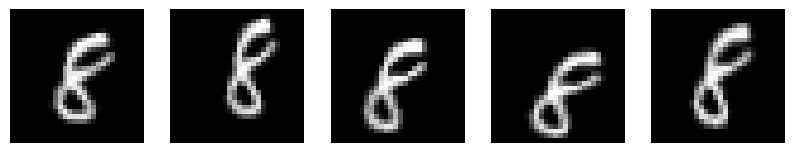

学習開始！水増しデータで特訓中...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.5866 - loss: 1.2171 - val_accuracy: 0.9640 - val_loss: 0.1208
Epoch 2/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9081 - loss: 0.3104 - val_accuracy: 0.9764 - val_loss: 0.0751
Epoch 3/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9378 - loss: 0.2108 - val_accuracy: 0.9845 - val_loss: 0.0519
Epoch 4/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9524 - loss: 0.1600 - val_accuracy: 0.9838 - val_loss: 0.0530
Epoch 5/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9598 - loss: 0.1413 - val_accuracy: 0.9879 - val_loss: 0.0413
Epoch 6/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9649 - loss: 0.1206 - val_accuracy: 0.9886 - val_loss: 0.0365
Epoch 7/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9695 - loss: 0.1080 - val_accuracy: 0.9869 - val_loss: 0.0404
Epoch 8/15
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.9712 - loss: 0.1008 - val_accurac

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. データの読み込み
print("データを読み込んでいます...")
train_data = pd.read_csv("/train.csv")

# 2. データ前処理（前回と同じ）
y = train_data["label"]
X = train_data.drop("label", axis=1)
X = X.values.reshape(-1,28,28,1)
X = X / 255.0

# 学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# --- ここが新技術！データ水増しの定義 ---
datagen = ImageDataGenerator(
    rotation_range=10,      # 10度まで回転させる（少し傾く）
    zoom_range=0.1, # 10%まで拡大縮小する（遠近の変化）
    width_shift_range=0.1, # 横にずらす
    height_shift_range=0.1, # 縦にずらす
)
# 注意: vertical_flip（上下反転）は数字が変わる(6->9)のでNG！

# 水増しがちゃんと動くか、1枚だけ試しに表示してみる
print("水増し画像の例を表示します...")
# 修正点1: X_trainがDataFrameなので、iloc[0]で最初の行を取得し、.valuesでNumPy配列に変換する
sample_img = X_train[0].reshape((1, 28, 28, 1))
plt.figure(figsize=(10,2))
for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(batch[0].reshape(28, 28), cmap='gray')
  plt.axis('off')
  if i == 4: break
plt.show()

# 3. モデル構築（層を少し増やして強化します）
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # もう一層追加して、より複雑な特徴（曲線の組み合わせなど）を理解させる
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5), # 過学習防止（勉強しすぎ防止）
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 4. 学習スタート（GPUの本領発揮！）
# 水増ししながら学習するので、fit ではなく fit_generator (新しいKerasではfitでOK) を使います
print("学習開始！水増しデータで特訓中...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64), # ここでリアルタイムに画像を生成！
    epochs=15, # 水増しするので、回数を多め（15周）にします
    validation_data=(X_val, y_val),
    verbose=1
)

In [8]:
from google.colab import files # Colab専用のダウンロード機能

print("--- Kaggle提出用データの作成 ---")

# 1. テストデータの読み込み
test_data = pd.read_csv("/test.csv")

# 2. 画像の形に整形 & 正規化 (0〜1に)
X_test = test_data.values.reshape(-1, 28, 28, 1)
X_test = X_test / 255.0

# 3. 予測 (もっとも確率が高い数字を選ぶ)
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

# 4. CSV保存
submission_file = "submission_aug_99.csv"
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),
    "Label": predictions
})
submission.to_csv(submission_file, index=False)

print(f"{submission_file} を作成しました。ダウンロードします...")

# 5. 自動ダウンロード (ブラウザがブロックした場合は許可してください)
files.download(submission_file)

--- Kaggle提出用データの作成 ---
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
submission_aug_99.csv を作成しました。ダウンロードします...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>